# 🏥 Visual AI in Healthcare with FiftyOne - MedSAM2 on CT Scans  
**Empowering medical imaging workflows with open-source tools and modern AI**

This notebook is part of the **“Visual AI in Healthcare with FiftyOne”** workshop. Here, we explore how to **load and prepare CT video data with MedSAM2 annotations** from Hugging Face into FiftyOne for visual AI workflows in healthcare.

🔬 **What you’ll learn in this notebook:**

- How to **load the BTCV-CT-as-video-MedSAM2 dataset** from Hugging Face using FiftyOne utilities  
- How to **preview CT scans as video sequences** within the FiftyOne App  
- How to **inspect and filter frame-level detections** to isolate relevant slices   

📚 **Part of the notebook series:**
1. `01_load_arcade_dataset.ipynb` – Load and visualize the ARCADE dataset.  
2. `02_load_deeplesion_balanced.ipynb` – Curate and balance the DeepLesion dataset.  
3. `03_vlms_analysis_arcade.ipynb` – Use VFMs like NVLabs_CRADIOV3 in dataset undersatnding for ARCADE. 
4. `04_finetune_yolo8_stenosis.ipynb` – Train and integrate YOLOv8 for stenosis detection.  
5. `05_medsam2_ct_scan.ipynb` – Run MedSAM2 on CT scans for segmentation.  
6. `06_nvidia_vista_segmentation.ipynb` – Explore NVIDIA-VISTA-3D.  
7. `07_medgemma_vqa.ipynb` – Perform visual question answering and classification with MedGemma.

All notebooks are standalone but are best experienced sequentially.


### ✅ Requirements

Please install all the requeriments for running this notebook

In [ ]:
#!pip install datasets fiftyone pandas

Clean up previous dataset (if needed)

Before loading the dataset, we ensure there's no existing dataset with the same name in the FiftyOne environment.

- The dataset we're working with is the **BTCV-CT-as-video-MedSAM2**, hosted on Hugging Face and loaded via FiftyOne.
- FiftyOne stores datasets locally, so we check if one with the same name exists and delete it to avoid conflicts.


In [1]:
import fiftyone as fo

# Name used internally by FiftyOne (it does not use slashes like 'Voxel51/BTCV-...')
dataset_name = "Voxel51/BTCV-CT-as-video-MedSAM2-dataset"

# Delete the dataset if it exists
if fo.dataset_exists(dataset_name):
    fo.delete_dataset(dataset_name)
    print(f"Deleted existing dataset: {dataset_name}")
else:
    print(f"No dataset found with name: {dataset_name}")


/Users/paularamos/Documents/FiftyOne_HealthCare_Workshop/health_care/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Deleted existing dataset: Voxel51/BTCV-CT-as-video-MedSAM2-dataset


### Load BTCV CT Scan Video Dataset from Hugging Face

In this step, we load a sample from the **BTCV-CT-as-video-MedSAM2** dataset using FiftyOne’s integration with Hugging Face.

- We import the dataset using `load_from_hub()` and keep only the first 2 samples to simplify our analysis.
- This dataset is structured as **videos of CT scans** with **MedSAM2-predicted segmentations**.
- We then **filter out all frames except the middle one (frame 100)** to focus on a single annotated frame for each video.
- This is necessary because MedSAM2 only propagates masks forward in video, and this step helps us simplify the visualization.


In [2]:
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
from fiftyone.utils.huggingface import load_from_hub


dataset = load_from_hub("Voxel51/BTCV-CT-as-video-MedSAM2-dataset")[:2]


# Retaining detections from a single frame in the middle
# Note that SAM2 only propagates segmentation masks forward in a video
(
    dataset
    .match_frames(F("frame_number") != 100)
    .set_field("frames.gt_detections", None)
    .save()
)

Loading dataset
Importing samples...
 100% |███████████████████| 30/30 [2.0ms elapsed, 0s remaining, 15.3K samples/s]      
Importing frames...
 100% |███████████████| 3779/3779 [74.9ms elapsed, 0s remaining, 50.4K samples/s]   
Migrating dataset 'Voxel51/BTCV-CT-as-video-MedSAM2-dataset' to v1.5.2


### 🛠️ Install and Validate `sam2` Package

To run MedSAM2 locally or inspect its behavior, we clone and install the official [facebookresearch/sam2](https://github.com/facebookresearch/sam2) repository.

However, an issue may arise during installation due to the version of `setuptools`. If you encounter a build error, modify the `pyproject.toml` file as follows:

**Fix for `setuptools` version issue:**

In the file `sam2/pyproject.toml`, update the dependency line:

```toml
# Before:
setuptools>=61.0

# After:
setuptools>=62.3.0,<75.9


In [3]:
#git clone https://github.com/facebookresearch/sam2.git && cd sam2
#pip install -e .

import sam2
print(hasattr(sam2, 'build_sam'))


False


### 🤖 Apply MedSAM2 Video Segmentation Model

We now load the **MedSAM2 video model** from the FiftyOne Model Zoo and apply it to our dataset. This model supports segmenting anatomical structures across frames in a medical video.

- **Model**: `med-sam-2-video-torch`  
- **Prompt**: Uses `frames.gt_detections` (bounding boxes) as the prompt to generate masks  
- **Output**: Stores results in `frames.pred_segmentations`


   0% ||--------------------| 0/2 [5.8ms elapsed, ? remaining, ? samples/s] 

/Users/paularamos/Documents/FiftyOne_HealthCare_Workshop/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/Users/paularamos/Documents/FiftyOne_HealthCare_Workshop/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 48/48 [03:34<00:00,  4.48s/it]

  50% |██████████/----------| 1/2 [3.7m elapsed, 3.7m remaining, 0.0 samples/s] 


/Users/paularamos/Documents/FiftyOne_HealthCare_Workshop/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/Users/paularamos/Documents/FiftyOne_HealthCare_Workshop/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 40/40 [03:22<00:00,  5.05s/it]

 100% |█████████████████████| 2/2 [7.1m elapsed, 0s remaining, 0.0 samples/s]   



INFO:eta.core.utils: 100% |█████████████████████| 2/2 [7.1m elapsed, 0s remaining, 0.0 samples/s]   



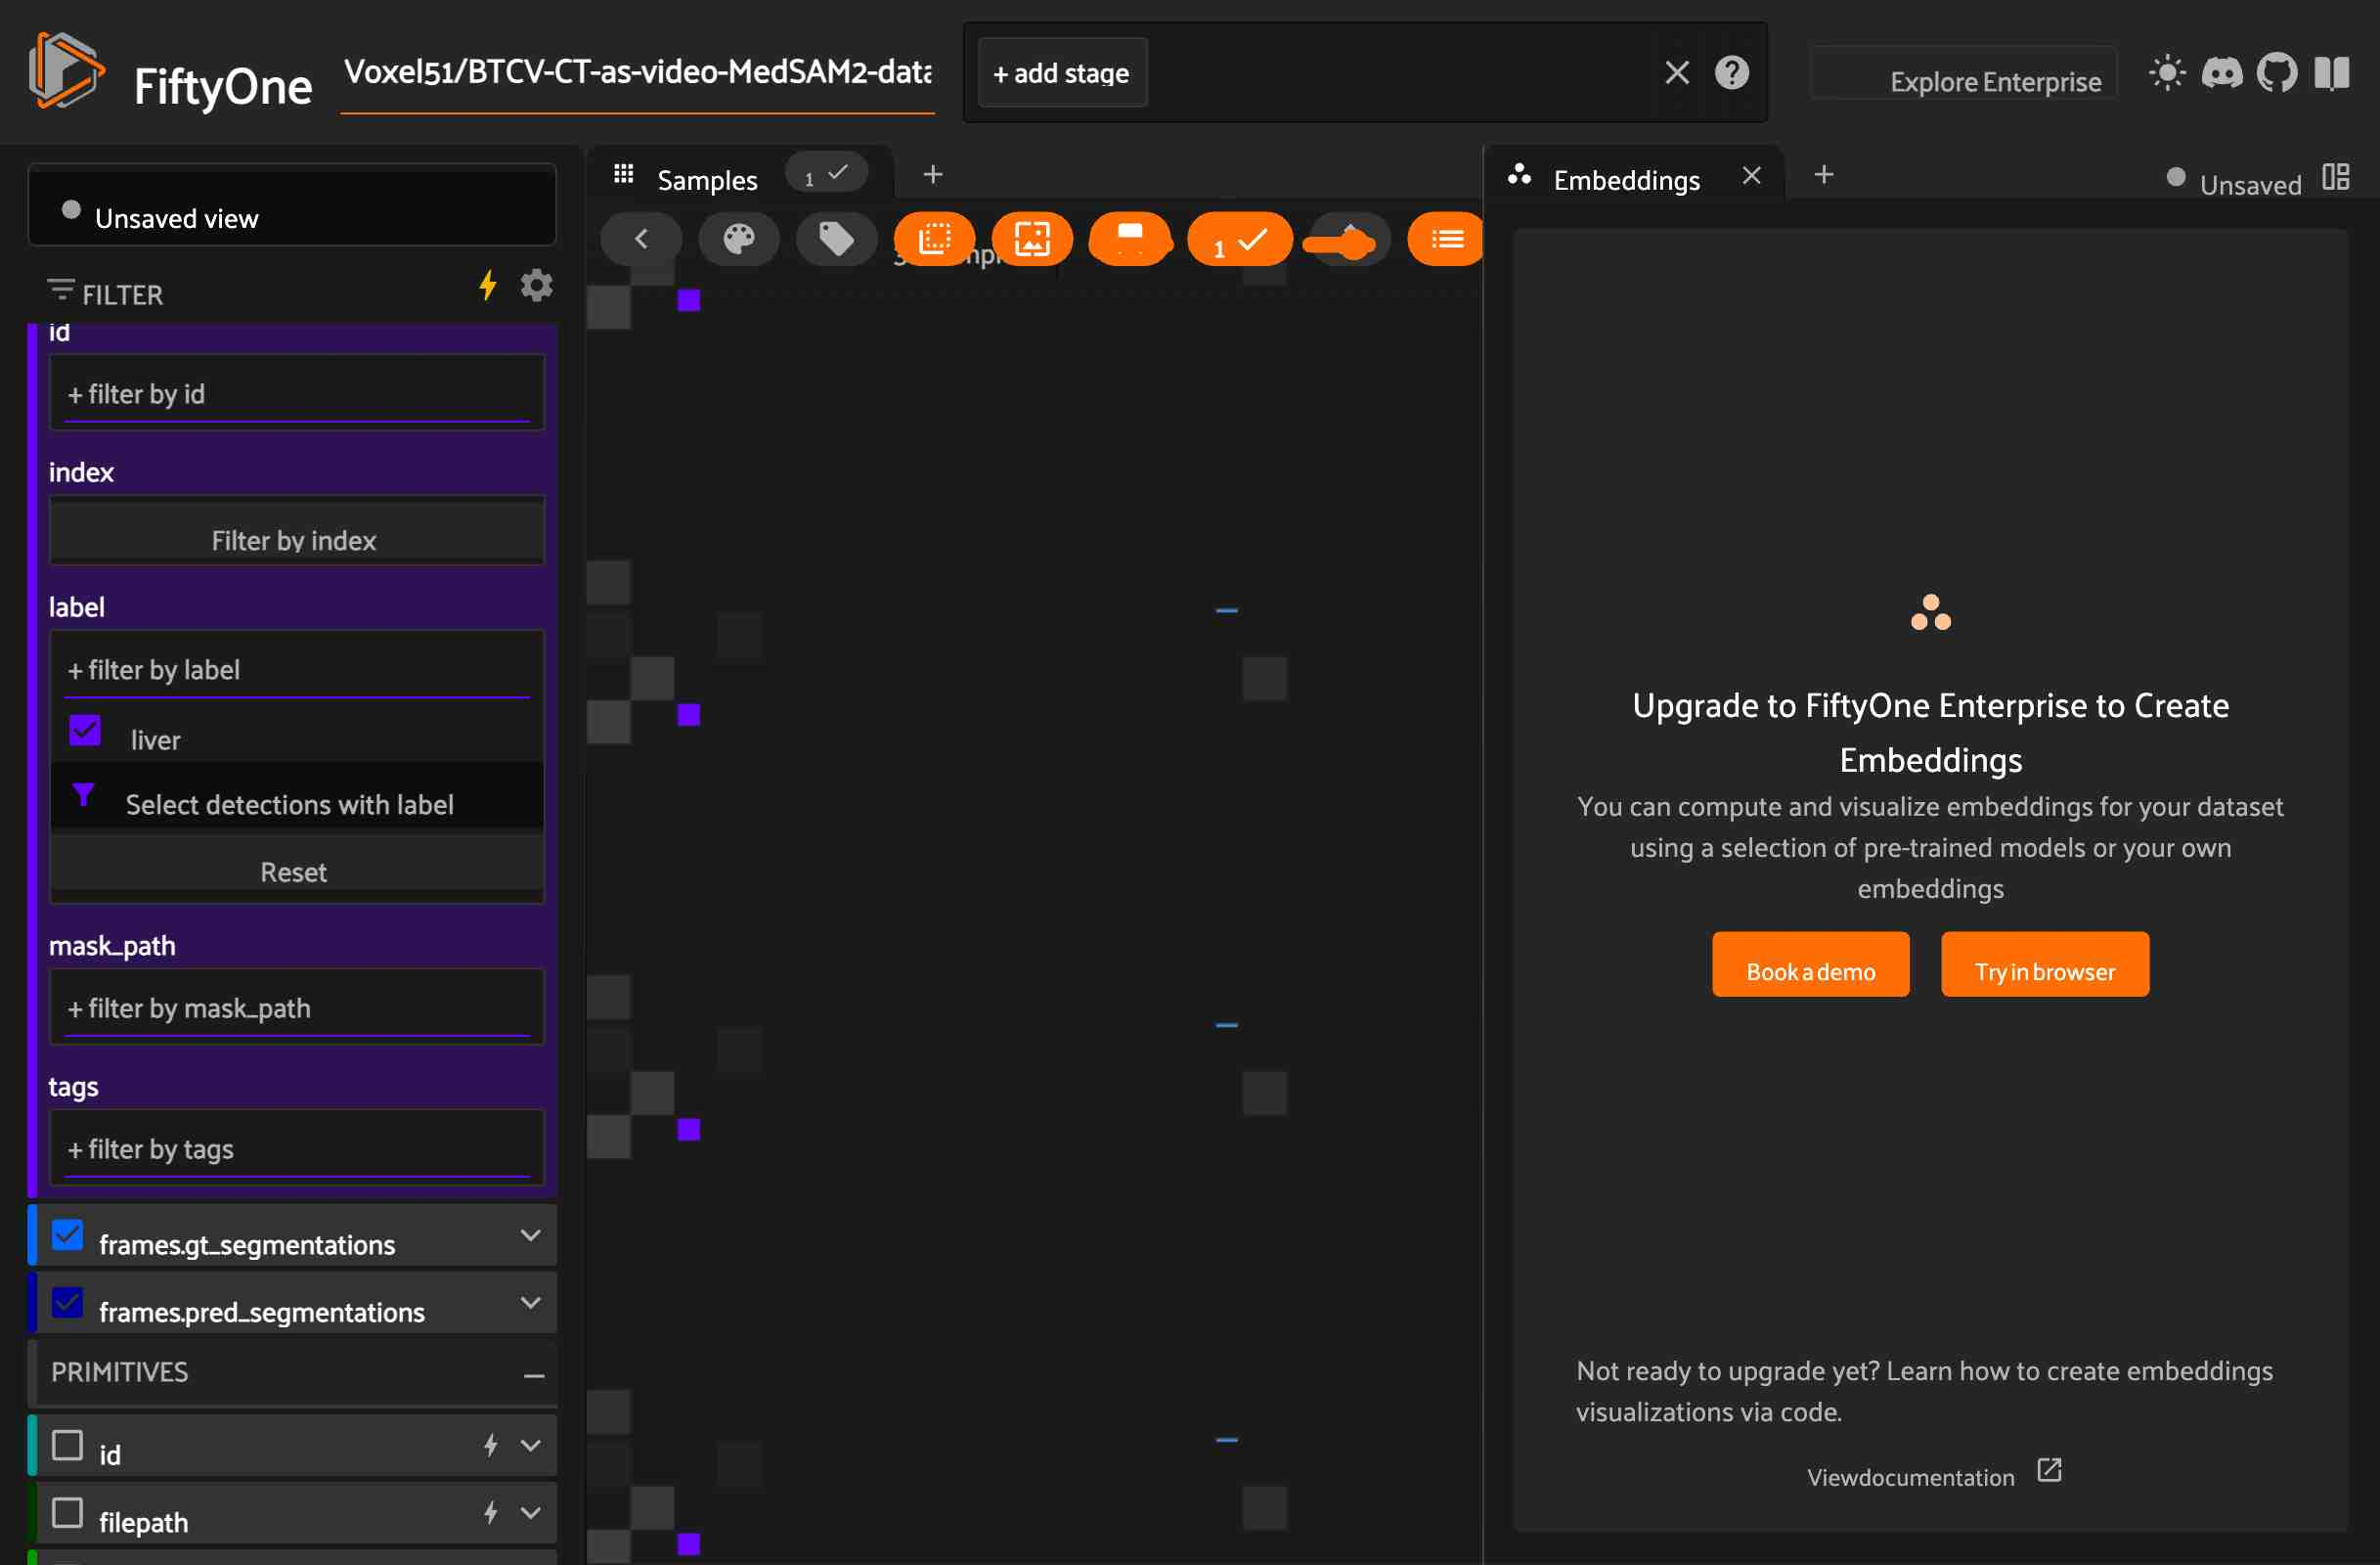

In [ ]:
model = foz.load_zoo_model("med-sam-2-video-torch")

# Segment inside boxes and propagate to all frames
dataset.apply_model(
    model,
    label_field="pred_segmentations",
    prompt_field="frames.gt_detections",
)

session = fo.launch_app(dataset)